<a href="https://colab.research.google.com/github/priyam197/OIBSIP_dataanalytics_05/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install & Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score
)
import joblib

# **Load Dataset**

In [ ]:
df = pd.read_csv("/content/creditcard.csv")

In [ ]:
print("Rows, Columns:", df.shape)
df.head()

Rows, Columns: (283145, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


# **Data Exploration**

Class
0.0    282652
1.0       492
Name: count, dtype: int64


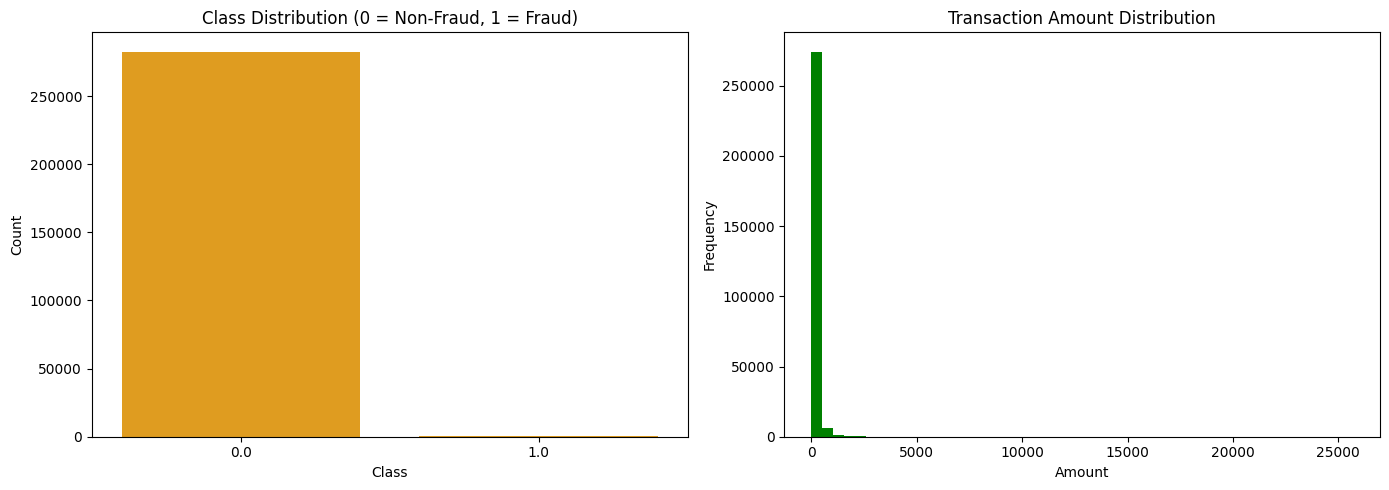

In [ ]:
# Class distribution
print(df['Class'].value_counts())
# Create a figure and a set of two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Plot 1: Class distribution (on the first subplot, axes[0]) ---
sns.countplot(x='Class', data=df, color='orange', ax=axes[0])
axes[0].set_title("Class Distribution (0 = Non-Fraud, 1 = Fraud)")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")

# --- Plot 2: Amount distribution (on the second subplot, axes[1]) ---
axes[1].hist(df['Amount'], bins=50, color='green')
axes[1].set_title("Transaction Amount Distribution")
axes[1].set_xlabel("Amount")
axes[1].set_ylabel("Frequency")

# Adjust layout to prevent titles and labels from overlapping
plt.tight_layout()

plt.show()

# **Feature Engineering**



In [ ]:
# Example 1: Create new feature (Transaction per Amount ratio)
df['Amount_log'] = np.log1p(df['Amount'])

# Example 2: Interaction feature
df['V1_V2_interaction'] = df['V1'] * df['V2']

# Example 3: Standard scaling (important for NN)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['Amount','Amount_log']] = scaler.fit_transform(df[['Amount','Amount_log']])

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,Amount_log,V1_V2_interaction
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244905,0.0,1.123086,0.098968
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.343420,0.0,-1.115423,0.317214
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.162007,0.0,1.681043,1.820416
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140317,0.0,1.008144,0.178979
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073943,0.0,0.669111,-1.016624


# **Preprocessing**

In [ ]:
# Check if there are missing values
print("Missing values in dataset:\n", df.isnull().sum())

# Drop rows where 'Class' is NaN
df = df.dropna(subset=['Class'])

# Separate features and labels again
X = df.drop('Class', axis=1)
y = df['Class']

# Standardize 'Time' and 'Amount'
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X[['Time','Amount']] = scaler.fit_transform(X[['Time','Amount']])

# Train-test split (now it will work)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("✅ Train size:", X_train.shape, " Test size:", X_test.shape)


Missing values in dataset:
 Time                 0
V1                   0
V2                   0
V3                   0
V4                   0
V5                   0
V6                   0
V7                   0
V8                   0
V9                   0
V10                  0
V11                  0
V12                  0
V13                  0
V14                  0
V15                  1
V16                  1
V17                  1
V18                  1
V19                  1
V20                  1
V21                  1
V22                  1
V23                  1
V24                  1
V25                  1
V26                  1
V27                  1
V28                  1
Amount               1
Class                1
Amount_log           1
V1_V2_interaction    0
dtype: int64
✅ Train size: (226515, 32)  Test size: (56629, 32)


In [ ]:
print("Rows after removing NaN in Class:", df.shape)


Rows after removing NaN in Class: (283144, 33)


# **Logistic Regression (Baseline Model)**

Logistic Regression Report:
               precision    recall  f1-score   support

         0.0       1.00      0.97      0.99     56531
         1.0       0.06      0.94      0.11        98

    accuracy                           0.97     56629
   macro avg       0.53      0.96      0.55     56629
weighted avg       1.00      0.97      0.98     56629

ROC AUC: 0.9776530413690303


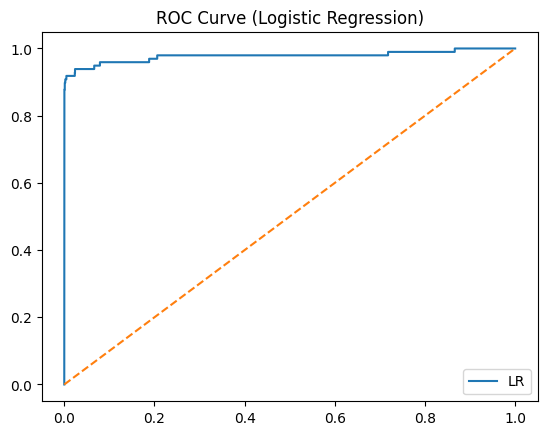

In [ ]:
lr = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)
lr.fit(X_train, y_train)

y_prob_lr = lr.predict_proba(X_test)[:,1]
y_pred_lr = lr.predict(X_test)

print("Logistic Regression Report:\n", classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lr))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
plt.plot(fpr, tpr, label="LR")
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve (Logistic Regression)")
plt.legend()
plt.show()


# **Random Forest (Stronger Model)**

Random Forest Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56531
         1.0       0.95      0.81      0.87        98

    accuracy                           1.00     56629
   macro avg       0.98      0.90      0.94     56629
weighted avg       1.00      1.00      1.00     56629

ROC AUC: 0.9631142421766782


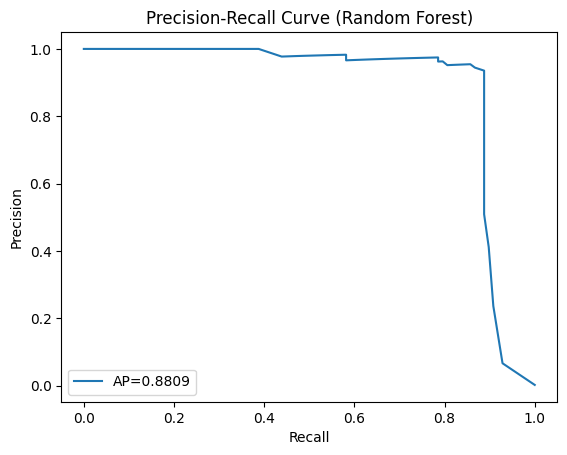

In [ ]:
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_prob_rf = rf.predict_proba(X_test)[:,1]
y_pred_rf = rf.predict(X_test)

print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob_rf)
ap = average_precision_score(y_test, y_prob_rf)
plt.plot(recall, precision, label=f"AP={ap:.4f}")
plt.title("Precision-Recall Curve (Random Forest)")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.legend()
plt.show()


# **Decision Tree Classifier**

Decision Tree Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56531
         1.0       0.68      0.84      0.75        98

    accuracy                           1.00     56629
   macro avg       0.84      0.92      0.87     56629
weighted avg       1.00      1.00      1.00     56629

ROC AUC: 0.9180224034564385


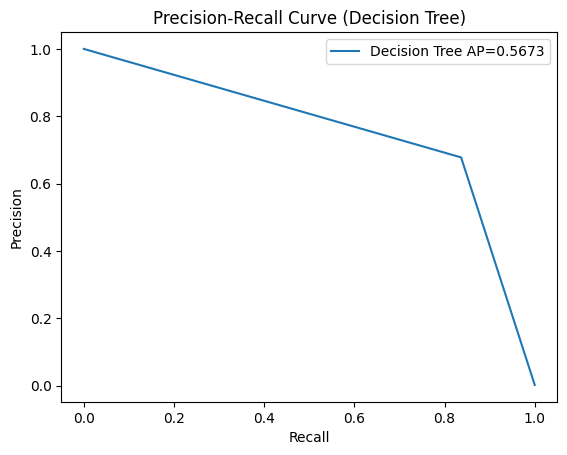

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_prob_dt = dt.predict_proba(X_test)[:,1]
y_pred_dt = dt.predict(X_test)

print("Decision Tree Report:\n", classification_report(y_test, y_pred_dt))
print("ROC AUC:", roc_auc_score(y_test, y_prob_dt))

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob_dt)
ap = average_precision_score(y_test, y_prob_dt)
plt.plot(recall, precision, label=f"Decision Tree AP={ap:.4f}")
plt.title("Precision-Recall Curve (Decision Tree)")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.legend()
plt.show()

# **Neural Network (MLP Classifier)**

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56531
         1.0       0.88      0.86      0.87        98

    accuracy                           1.00     56629
   macro avg       0.94      0.93      0.93     56629
weighted avg       1.00      1.00      1.00     56629

ROC AUC: 0.9720801554068763


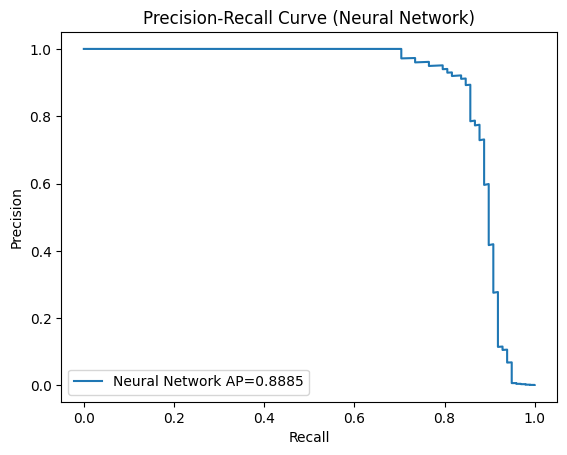

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(64,32),
                    activation='relu',
                    solver='adam',
                    max_iter=20,
                    random_state=42)

mlp.fit(X_train, y_train)

y_prob_mlp = mlp.predict_proba(X_test)[:,1]
y_pred_mlp = mlp.predict(X_test)

print("Neural Network Report:\n", classification_report(y_test, y_pred_mlp))
print("ROC AUC:", roc_auc_score(y_test, y_prob_mlp))

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob_mlp)
ap = average_precision_score(y_test, y_prob_mlp)
plt.plot(recall, precision, label=f"Neural Network AP={ap:.4f}")
plt.title("Precision-Recall Curve (Neural Network)")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.legend()
plt.show()


# **Handle Imbalance (Undersampling Example)**

In [ ]:
train_df = X_train.copy()
train_df['Class'] = y_train

frauds = train_df[train_df['Class']==1]
nonfrauds = train_df[train_df['Class']==0].sample(n=len(frauds), random_state=42)
balanced_train = pd.concat([frauds, nonfrauds])

X_bal = balanced_train.drop('Class', axis=1)
y_bal = balanced_train['Class']

rf_bal = RandomForestClassifier(n_estimators=100, random_state=42)
rf_bal.fit(X_bal, y_bal)

y_pred_bal = rf_bal.predict(X_test)
print("Balanced Random Forest Report:\n", classification_report(y_test, y_pred_bal))


Balanced Random Forest Report:
               precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     56531
         1.0       0.06      0.94      0.12        98

    accuracy                           0.98     56629
   macro avg       0.53      0.96      0.55     56629
weighted avg       1.00      0.98      0.99     56629



# **Threshold Tuning**

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob_rf)
f1_scores = [2*(p*r)/(p+r) if (p+r)>0 else 0 for p, r in zip(precisions, recalls)]

best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
print("Best Threshold:", best_thresh, " F1 Score:", f1_scores[best_idx])

y_pred_thresh = (y_prob_rf >= best_thresh).astype(int)
print("Classification Report (Best Threshold):\n", classification_report(y_test, y_pred_thresh))


Best Threshold: 0.33  F1 Score: 0.9109947643979057
Classification Report (Best Threshold):
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56531
         1.0       0.94      0.89      0.91        98

    accuracy                           1.00     56629
   macro avg       0.97      0.94      0.96     56629
weighted avg       1.00      1.00      1.00     56629



# **Save Model & Scaler**

In [ ]:
joblib.dump(rf, "fraud_model_rf.joblib")
joblib.dump(scaler, "cc_scaler.joblib")
print("✅ Model and scaler saved successfully.")


✅ Model and scaler saved successfully.


# **Real-Time Prediction Simulation**

In [ ]:
# Example: predict for first 5 test transactions
sample = X_test.iloc[:5].copy()
probs = rf.predict_proba(sample)[:,1]
preds = (probs >= best_thresh).astype(int)

result = sample.copy()
result['fraud_prob'] = probs
result['predicted_label'] = preds
result


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V24,V25,V26,V27,V28,Amount,Amount_log,V1_V2_interaction,fraud_prob,predicted_label
235217,1.141485,-0.439240,0.884552,0.671552,-1.043610,0.802213,-1.291235,1.231376,-0.316586,-0.303599,...,0.092637,0.312307,-0.216922,0.102810,0.136593,-0.350187,-1.485062,-0.388530,0.0,0
198193,0.804383,1.597220,-1.523291,-1.168096,-1.719281,-0.298728,0.927337,-0.735751,0.392829,2.014107,...,-1.589009,-0.361700,-0.058688,0.038919,-0.040651,0.378642,1.243960,-2.433030,0.0,0
72253,-0.840726,1.087300,-0.154770,0.794644,1.313869,-0.545867,0.311203,-0.365560,0.178116,0.669898,...,0.047010,0.702228,-0.304679,0.049254,0.018170,-0.198751,0.320178,-0.168282,0.0,0
173434,0.573872,2.030159,-1.111221,-0.572603,-1.153576,-1.019408,-0.195586,-1.006486,0.083154,-0.362314,...,0.673190,-0.979481,0.806203,-0.080901,-0.043889,-0.152384,0.474236,-2.255956,0.0,0
255559,1.331599,2.075482,0.174134,-1.720837,0.403508,0.467774,-0.842498,0.208308,-0.251595,0.449583,...,0.490713,-0.240957,0.173713,-0.061046,-0.029996,-0.339816,-0.983704,0.361413,0.0,0


# **Recommendations**
* Replace undersampling with class_weight='balanced' in your model to use all non-fraud data.

* Engineer the transaction Time column to extract the Hour-of-Day feature, capturing temporal fraud patterns.

* Upgrade your model to Gradient Boosting (XGBoost or LightGBM) for higher performance on imbalanced data.